<a href="https://colab.research.google.com/github/franciscourbina/Proyecto_grupo12a_IA/blob/main/seg_miocardio_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import os
import sys
import time
import random 


import tensorflow as tf

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Importación de archivos.
path='/content/drive/MyDrive/Seg_miocardio/dataset/'

X_train = np.float32(np.load(path + 'train_imgs.npy'))[:,:,:,np.newaxis]
Y_train = np.float32(np.load(path + 'train_annot.npy'))[:,:,:,np.newaxis]

X_val = np.float32(np.load(path + 'val_imgs.npy'))[:,:,:,np.newaxis]
Y_val = np.float32(np.load(path + 'val_annot.npy'))[:,:,:,np.newaxis]

X_test = np.float32(np.load(path + 'test_imgs.npy'))[:,:,:,np.newaxis]
Y_test = np.float32(np.load(path + 'test_annot.npy'))[:,:,:,np.newaxis]



In [ ]:
# Normalización 

X_train=X_train/255
X_test=X_test/255
X_val=X_val/255


In [ ]:
# Cambiar etiquetas y dejar solo miocardio o fondo. Se reemplazan los 2 por un 0
Y_train=np.where(Y_train==2, 0, Y_train)
Y_val=np.where(Y_val==2, 0, Y_val)
Y_test=np.where(Y_test==2, 0, Y_test)


In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # el -1 es para maximizar el coeficiente

In [ ]:
#Smooth es para prevenir las divisiones por 0
def dice_coef(y_true, y_pred,smooth=1e-6):
    y_true_f = K.flatten(y_true) # y_true stretch to one dimension
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return (1 -dice_coef(y_true, y_pred))

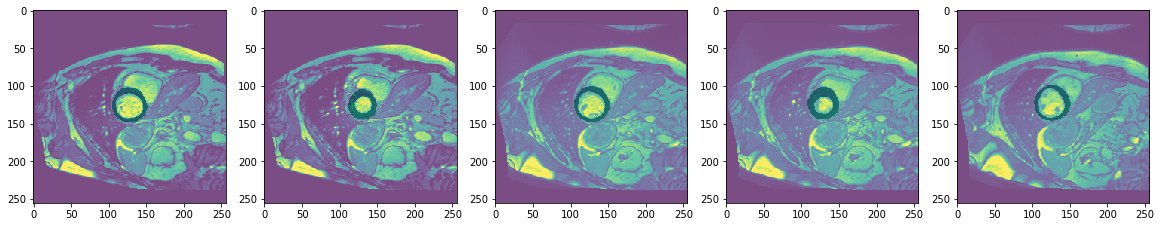

In [ ]:
# Visualización 5 imágenes aleatorias

indices = np.random.randint(0, len(X_train), size=5)

fig, axs = plt.subplots(1, 5, figsize=(20,10))
for i in range(len(indices)):
  axs[i].imshow(Y_test[i,:,:,0], cmap='Greens', interpolation="none", alpha=1)
  axs[i].imshow(X_test[i,:,:,0], interpolation="none", alpha=0.7)
plt.show()

In [ ]:
# Modelo U-net sin batchnormalization con optimizador SGD y función costos MSE, puede modificarse de ser requerido.
def MyModel(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contracción:
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'sgd', loss = 'mse', metrics = [tf.keras.metrics.MeanIoU(num_classes=2),
                                                                               tf.keras.metrics.Recall(),
                                                                               tf.keras.metrics.Precision()])

    
    return model




In [ ]:
# Modelo U-net con batchnormalization y función de costos al coeficiente de jaccard
def MyModel_batchnorm(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contracción:
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    b1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(b1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(b1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    b2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(b2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(b2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    b3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(b3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(b3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(b4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(b4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(b5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # b5 = BatchNormalization()

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    b6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(b6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    b6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    b7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(b7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    b7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(b7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    b8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(b8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    b8 = BatchNormalization()(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(b8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    b9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(b9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    b9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(b9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = jacard_coef_loss, metrics = [tf.keras.metrics.MeanIoU(num_classes=2),
                                                                               tf.keras.metrics.Recall(),
                                                                               tf.keras.metrics.Precision()])

    
    return model




In [ ]:
# Modelo U-net con 2 bloques extras en el encoder y decoder, batchnormalization y coeficiente jacard para loss function
def MyModel_deep_batchnorm2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contracción:
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    b1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(b1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(b1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    b2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(b2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(b2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    b3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(b3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(b3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(b4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(b4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(b5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    b5 = BatchNormalization()(c5)
    p5 = MaxPooling2D((2, 2))(b5)

    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    b6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(b6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    b6 = BatchNormalization()(c6)
    p6 = MaxPooling2D((2, 2))(b6)
    
    c7 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p6)
    b7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(b7)
    c7 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
   


    #Expansive path 
     
    u14 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c7)
    u14 = concatenate([u14, c6], axis=3)
    c14 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u14)
    b14 = BatchNormalization()(c14)
    c14 = Dropout(0.1)(b14)
    c14 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c14)
    b14 = BatchNormalization()(c14)
  #
    u15 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b14)
    u15 = concatenate([u15, c5])
    c15 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u15)
    b15 = BatchNormalization()(c15)
    c15 = Dropout(0.2)(b15)
    c15 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    b15 = BatchNormalization()(c15)


    u16 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b15)
    u16 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u16)
    u16 = concatenate([u16, c4])
    c16 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u16)
    b16 = BatchNormalization()(c16)
    c16 = Dropout(0.2)(b16)
    c16 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c16)
    b16 = BatchNormalization()(c16)

    u17 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b16)
    u17 = concatenate([u17, c3])
    c17 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u17)
    b17 = BatchNormalization()(c17)
    c17 = Dropout(0.2)(b17)
    c17 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c17)
    b17 = BatchNormalization()(c17)

    u18 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(b17)
    u18 = concatenate([u18, c2])
    c18 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u18)
    b18 = BatchNormalization()(c18)
    c18 = Dropout(0.1)(b18)
    c18 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c18)
    b18 = BatchNormalization()(c18)
     
    u19 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(b18)
    u19 = concatenate([u19, c1], axis=3)
    c19 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u19)
    b19 = BatchNormalization()(c19)
    c19 = Dropout(0.1)(b19)
    c19 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c19)
    b19 = BatchNormalization()(c19)


    outputs = Conv2D(1, (1, 1), activation='sigmoid')(b19)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = jacard_coef_loss, metrics = [tf.keras.metrics.MeanIoU(num_classes=2),
                                                                               tf.keras.metrics.Recall(),
                                                                               tf.keras.metrics.Precision()])

    
    return model

In [ ]:
height , width, channels = np.shape(X_test[0])

model=MyModel_batchnorm(height, width,channels)  # este debe modificarse en función de que experimento se desee plantear
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 256, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [ ]:
backs=[tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss')]


exp_1 = model.fit(X_train, Y_train, 
                    batch_size = 64, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True,
                    callbacks=backs)

In [ ]:
backs=[tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_mean_io_u')]

exp_2 = model.fit(X_train, Y_train,   ### experimento con mse loss function y ADAM
                    batch_size = 64, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True,
                  callbacks=backs)

In [ ]:
backs=[tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_mean_io_u')]

exp_2_2 = model.fit(X_train, Y_train,   ### experimento con mse loss function y SGD
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True,
                  callbacks=backs)

In [ ]:
backs=[tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss')]

exp_3 = model.fit(X_train, Y_train,   ### experimento con dice loss function 
                    batch_size = 64, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True,
                  callbacks=backs)

In [ ]:

exp_4 = model.fit(X_train[0:4000], Y_train[0:4000],   ### experimento con focal loss function  #con adam , sgd se quedo pegado
                    batch_size = 64, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True)

In [ ]:
## batch normalization con dice_coef


exp_5 = model.fit(X_train, Y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True)

In [ ]:
## batch normalization con jacar coef

exp_6 = model.fit(X_train, Y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True)

In [ ]:
# carga de algún modelo previo entrenado de ser requerido. Se debe modificar el path para que sea ejecutado. 
my_model = tf.keras.models.load_model(path+'saved_model/jose_truco_batch_jacard', custom_objects={'jacard_coef_loss': jacard_coef_loss})


Text(0, 0.5, 'Mean IOU')

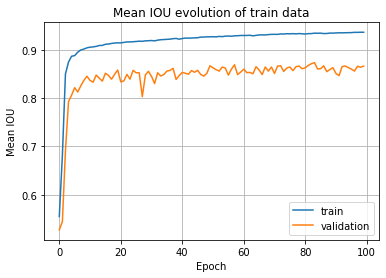

In [ ]:
plt.plot(metrics_['mean_io_u_1'],label='train')
plt.plot(metrics_['val_mean_io_u_1'],label='validation')
plt.grid()
plt.legend()
plt.title('Mean IOU evolution of train data')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')


Text(0, 0.5, 'Loss function')

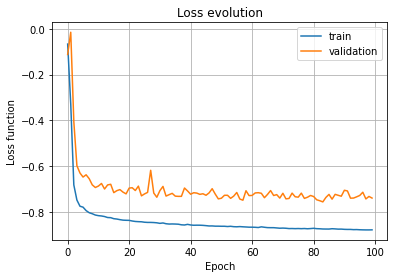

In [ ]:
plt.plot(metrics_['loss'],label='train')
plt.plot(metrics_['val_loss'],label='validation')
plt.grid()
plt.legend()
plt.title('Loss evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss function')

Text(0, 0.5, 'Precision')

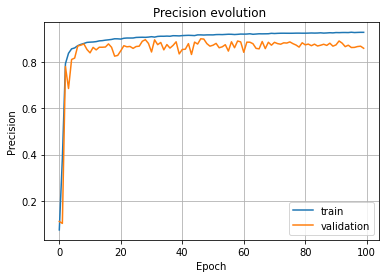

In [ ]:
plt.plot(metrics_['precision_1'],label='train')
plt.plot(metrics_['val_precision_1'],label='validation')
plt.grid()
plt.legend()
plt.title('Precision evolution ')
plt.xlabel('Epoch')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

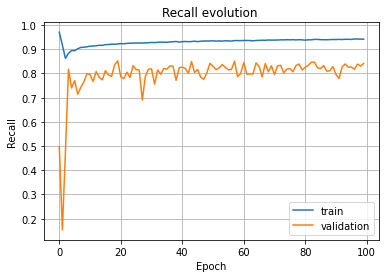

In [ ]:
plt.plot(metrics_['recall_1'],label='train')
plt.plot(metrics_['val_recall_1'],label='validation')
plt.grid()
plt.legend()
plt.title('Recall evolution ')
plt.xlabel('Epoch')
plt.ylabel('Recall')

In [ ]:
#cálculo predicciones

preds_train = my_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = my_model.predict(X_val[int(X_val.shape[0]*0.9):], verbose=1)
preds_test = my_model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



39/39 [==============================] - 7s 187ms/step


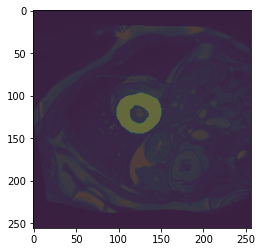

In [ ]:
# Se muestra el resultado de alguna predicción sobre una imagen de test.
ix =35
plt.imshow(X_train[ix,:,:,0],alpha=0.5)
plt.imshow(np.squeeze(Y_train[ix,:,:,0]),alpha=0.5)
img_pred_tmp = np.squeeze(preds_train_t[ix,:,:,0])
plt.imshow(img_pred_tmp, alpha=0.5, cmap='inferno')
plt.show()


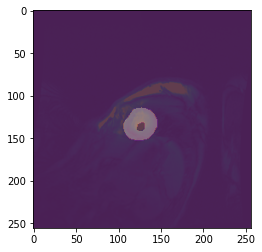

In [ ]:
# Se repite lo anterior en el conjunto de validación
plt.imshow(X_val[int(X_val.shape[0]*0.9):][ix,:,:,0],alpha=0.5)
img_pred_tmp=np.squeeze(Y_val[int(Y_val.shape[0]*0.9):][ix,:,:,0])
plt.imshow(img_pred_tmp, alpha=0.5, cmap='inferno')


plt.imshow(np.squeeze(preds_val_t[ix,:,:,0]),alpha=0.5)
plt.show()

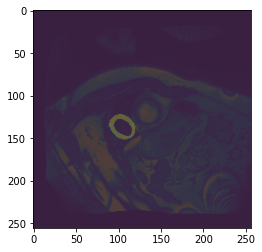

In [ ]:
# Ahora con una imagen del conjunto de test.
ix = random.randint(0, len(preds_val_t))
plt.imshow(X_test[ix,:,:,0],alpha=0.5)
plt.imshow(np.squeeze(Y_test[int(Y_test.shape[0]*0.9):][ix,:,:,0]),alpha=0.5)
plt.imshow(np.squeeze(preds_test_t[ix,:,:,0]),alpha=0.5,cmap='inferno')
plt.show()

In [ ]:
# histograma
image_test = X_test
prediccion = my_model.predict(image_test) > 0.5

prediccion2 = prediccion.astype(float)
prediccion2 = tf.convert_to_tensor(prediccion, dtype=float)

IoU = []
for i in range(1240):
  test_imag = prediccion2[i][:,:,0] 
  target = Y_test[i][:,:,0]
  coef = jacard_coef(target, test_imag)
  IoU.append(coef)


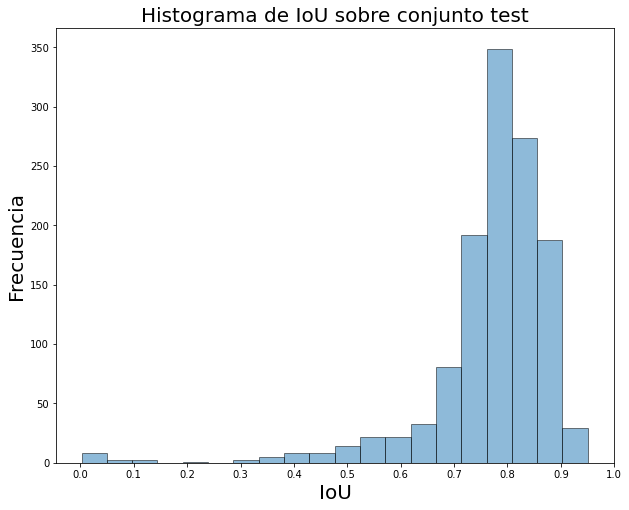

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(IoU,bins = 20, alpha=0.5, edgecolor = 'black')
plt.xticks(np.arange(0,1.1, 0.1))
plt.xlabel('IoU', fontsize=20)
plt.ylabel('Frecuencia', fontsize=20)
plt.title('Histograma de IoU sobre conjunto test', fontsize=20)
plt.show()

In [ ]:
#Exploración resultados histograma

IoU_ordenado=tf.sort(IoU)
print(IoU_ordenado[0])
print(IoU_ordenado[1])
print(IoU_ordenado[2])

print(IoU_ordenado[86])

print('corte al 75%:',IoU_ordenado[342])
print('corte al 80%:',IoU_ordenado[691])


print(IoU_ordenado[1237])
print(IoU_ordenado[1238])
print(IoU_ordenado[1239])

tf.Tensor(0.0020325202, shape=(), dtype=float32)
tf.Tensor(0.0024813896, shape=(), dtype=float32)
tf.Tensor(0.002624672, shape=(), dtype=float32)
tf.Tensor(0.6012176, shape=(), dtype=float32)
corte al 75%: tf.Tensor(0.75, shape=(), dtype=float32)
corte al 80%: tf.Tensor(0.8, shape=(), dtype=float32)
tf.Tensor(0.93219376, shape=(), dtype=float32)
tf.Tensor(0.9427516, shape=(), dtype=float32)
tf.Tensor(0.9504863, shape=(), dtype=float32)


In [ ]:
# indice_peor_1=0.0020325202
# indice_peor_2=0.0024813896
# indice_peor_3=0.002624672

indice_peor_1= IoU.index(0.0020325202)
print(indice_peor_1)
prediccion_peor_1 = prediccion2[indice_peor_1,:,:,0]
anot_peor_1 = Y_test[indice_peor_1,:,:,0]

indice_peor_2= IoU.index(0.0024813896)
print(indice_peor_2)
prediccion_peor_2 = prediccion2[indice_peor_1,:,:,0]
anot_peor_2 = Y_test[indice_peor_1,:,:,0]

indice_peor_3= IoU.index(0.002624672)
print(indice_peor_3)
prediccion_peor_3 = prediccion2[indice_peor_1,:,:,0]
anot_peor_3 = Y_test[indice_peor_1,:,:,0]

183
239
127


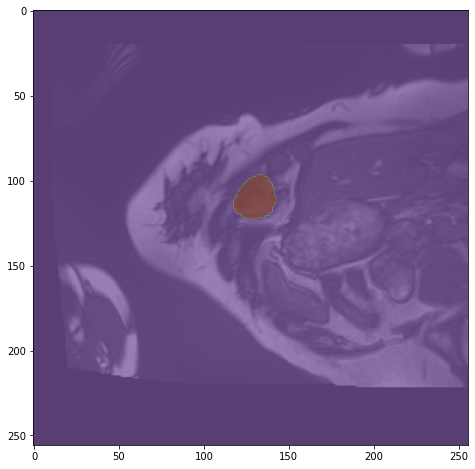

In [ ]:
 # peor caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_peor_1,:,:,0],alpha=0.5,cmap='gray')
plt.imshow(Y_test[indice_peor_1,:,:,0], alpha=0.3, cmap='rainbow')
plt.imshow(prediccion_peor_1, alpha=0.3, cmap='inferno')

plt.show()

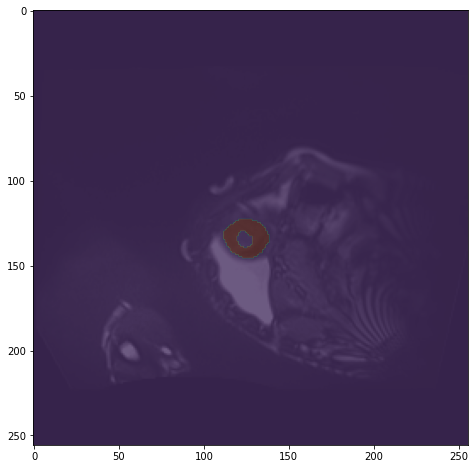

In [ ]:
 # siguiente peor caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_peor_2,:,:,0],alpha=0.6,cmap='gray')
plt.imshow(Y_test[indice_peor_2,:,:,0], alpha=0.3, cmap='rainbow')
plt.imshow(prediccion_peor_2, alpha=0.5, cmap='inferno')

plt.show()

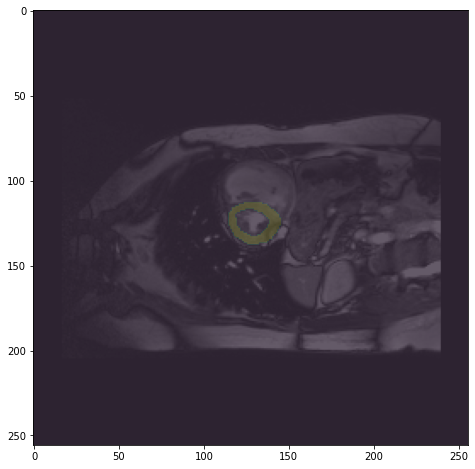

In [ ]:
 # siguiente siguiente peor caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_peor_3,:,:,0],alpha=0.6,cmap='gray')
plt.imshow(Y_test[indice_peor_3,:,:,0], alpha=0.3, cmap='viridis')
plt.imshow(prediccion_peor_3, alpha=0.5, cmap='inferno')

plt.show()

In [ ]:
# indice_mejor_1=0.9504863
# indice_mejor_2=0.9427516
# indice_mejor_3=0.93219376

indice_mejor_1= IoU.index(0.9504863)
print(indice_mejor_1)
prediccion_mejor_1 = prediccion2[indice_mejor_1,:,:,0]
anot_mejor_1 = Y_test[indice_peor_1,:,:,0]

indice_mejor_2= IoU.index(0.9427516)
print(indice_mejor_2)
prediccion_mejor_2 = prediccion2[indice_mejor_2,:,:,0]
anot_mejor_2 = Y_test[indice_mejor_2,:,:,0]

indice_mejor_3= IoU.index(0.93219376)
print(indice_mejor_3)
prediccion_mejor_3 = prediccion2[indice_mejor_3,:,:,0]
anot_mejor_3 = Y_test[indice_mejor_3,:,:,0]

In [ ]:
 # mejor caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_mejor_1,:,:,0],alpha=0.3,cmap='gray')
plt.imshow(Y_test[indice_mejor_1,:,:,0], alpha=0.3, cmap='rainbow')
plt.imshow(prediccion_mejor_1, alpha=0.5, cmap='inferno')

plt.show()

In [ ]:
 # anterior caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_mejor_2,:,:,0],alpha=0.6,cmap='gray')
plt.imshow(prediccion_mejor_2, alpha=0.3, cmap='rainbow')
plt.imshow(Y_test[indice_mejor_2,:,:,0], alpha=0.5, cmap='inferno')

plt.show()

In [ ]:
 # anterior caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_mejor_3,:,:,0],alpha=0.6,cmap='gray')
plt.imshow(prediccion_mejor_3, alpha=0.3, cmap='rainbow')
plt.imshow(Y_test[indice_mejor_3,:,:,0], alpha=0.5, cmap='inferno')

plt.show()

In [ ]:
  
indice_peor = np.where(IoU == np.min(IoU))
prediccion_peor = prediccion2[indice_peor[0][0],:,:,0]
anot_peor = Y_test[indice_peor,:,:,0]

In [ ]:
prediccion_peor.shape

In [ ]:
 # peor caso
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_peor[0][0],:,:,0],alpha=0.5,cmap='gray')
plt.imshow(Y_test[indice_peor[0][0],:,:,0], alpha=0.3, cmap='spring')
plt.imshow(prediccion_peor, alpha=0.5, cmap='inferno')


plt.show()

In [ ]:
# mejor caso
indice_mejor = np.where(IoU == np.max(IoU))
prediccion_mejor = prediccion2[indice_mejor[0][0],:,:,0]
anot_mejor = Y_test[indice_mejor,:,:,0]


In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(X_test[indice_mejor[0][0],:,:,0],alpha=0.3,cmap='gray')
plt.imshow(Y_test[indice_mejor[0][0],:,:,0], alpha=0.3,cmap='spring')
plt.imshow(prediccion_mejor, alpha=0.5, cmap='inferno')
plt.show()

## Anexo de metricas de resultados en experimentos

In [ ]:
#dice_loss
metrics_={'loss': [0.6594910025596619,
  0.34329861402511597,
  0.23703014850616455,
  0.17961442470550537,
  0.14930854737758636,
  0.12983907759189606,
  0.10852768272161484,
  0.09774178266525269,
  0.09046302735805511,
  0.0881069004535675,
  0.08465616405010223,
  0.07930028438568115,
  0.07834038138389587,
  0.07512134313583374,
  0.07437198609113693,
  0.07223383337259293,
  0.07097657024860382,
  0.06986751407384872,
  0.06909255683422089,
  0.06761591136455536,
  0.06677185744047165,
  0.06610903888940811,
  0.06436534970998764,
  0.06373875588178635,
  0.06325284391641617,
  0.06338205933570862,
  0.061648204922676086,
  0.0607452467083931,
  0.060230500996112823,
  0.06055435538291931,
  0.0594436340034008,
  0.059196263551712036,
  0.05852939561009407,
  0.057965829968452454,
  0.057479288429021835,
  0.05703815817832947,
  0.05661926418542862,
  0.05597704276442528,
  0.055569007992744446,
  0.055751901119947433,
  0.05578378215432167,
  0.055166978389024734,
  0.05485140159726143],
 'mean_io_u_1': [0.5438870787620544,
  0.7373971939086914,
  0.8001470565795898,
  0.8348351716995239,
  0.8412821888923645,
  0.7576749324798584,
  0.6370985507965088,
  0.6220568418502808,
  0.6311935186386108,
  0.6349486112594604,
  0.6425861120223999,
  0.6513936519622803,
  0.65007483959198,
  0.6645023822784424,
  0.6662481427192688,
  0.670743465423584,
  0.6725596189498901,
  0.6750907897949219,
  0.6758953928947449,
  0.6801578402519226,
  0.6769766807556152,
  0.6826132535934448,
  0.6839398145675659,
  0.6837083101272583,
  0.6863619089126587,
  0.6855519413948059,
  0.6877281069755554,
  0.6899306774139404,
  0.6874293684959412,
  0.6901030540466309,
  0.690426230430603,
  0.688697338104248,
  0.6944719552993774,
  0.6937949657440186,
  0.6928880214691162,
  0.6949185729026794,
  0.6970294713973999,
  0.7010610103607178,
  0.6977635025978088,
  0.6955124139785767,
  0.6988082528114319,
  0.6994264721870422,
  0.7010818123817444],
 'precision_1': [0.09022205322980881,
  0.6674278378486633,
  0.7419739961624146,
  0.7981675863265991,
  0.8294129967689514,
  0.842197835445404,
  0.8574843406677246,
  0.8678089380264282,
  0.8772008419036865,
  0.880969762802124,
  0.8842248320579529,
  0.8917694091796875,
  0.8926743865013123,
  0.8967052698135376,
  0.898232638835907,
  0.900538444519043,
  0.9022426605224609,
  0.9038411974906921,
  0.9052320122718811,
  0.906484842300415,
  0.9074200987815857,
  0.908803403377533,
  0.9104592800140381,
  0.9109464287757874,
  0.9118385910987854,
  0.9116123914718628,
  0.9138762950897217,
  0.9148546457290649,
  0.915398895740509,
  0.9150543808937073,
  0.9166802167892456,
  0.9165251851081848,
  0.917595624923706,
  0.9178082942962646,
  0.9193696975708008,
  0.919531524181366,
  0.9206222295761108,
  0.9210261702537537,
  0.921576201915741,
  0.9214211106300354,
  0.9215871691703796,
  0.9222620129585266,
  0.9236454963684082],
 'recall_1': [0.4624136686325073,
  0.644230842590332,
  0.7818910479545593,
  0.8385303616523743,
  0.8641746044158936,
  0.876112163066864,
  0.8843334913253784,
  0.8902686238288879,
  0.8950138092041016,
  0.8954929113388062,
  0.9000639319419861,
  0.9048671126365662,
  0.9061533212661743,
  0.9098511934280396,
  0.9100730419158936,
  0.9126557111740112,
  0.9138971567153931,
  0.9150332808494568,
  0.9151604771614075,
  0.9181060194969177,
  0.918558657169342,
  0.9192801713943481,
  0.921497106552124,
  0.9226435422897339,
  0.922617495059967,
  0.9229336380958557,
  0.9249181151390076,
  0.9259309768676758,
  0.926788330078125,
  0.9264315962791443,
  0.9275912642478943,
  0.9278932809829712,
  0.9286115169525146,
  0.9298065900802612,
  0.9293665289878845,
  0.9304649829864502,
  0.9302583336830139,
  0.9314427375793457,
  0.9317746758460999,
  0.9316105246543884,
  0.9315834641456604,
  0.9321578145027161,
  0.9316996932029724],
 'val_loss': [0.530709981918335,
  0.38326528668403625,
  0.2749907672405243,
  0.2623120844364166,
  0.2242092788219452,
  0.1927347630262375,
  0.18565934896469116,
  0.18187324702739716,
  0.16685988008975983,
  0.16848351061344147,
  0.16051256656646729,
  0.14919766783714294,
  0.15173977613449097,
  0.14774711430072784,
  0.15589402616024017,
  0.15021578967571259,
  0.15425820648670197,
  0.1586938500404358,
  0.15046681463718414,
  0.1559448093175888,
  0.14437690377235413,
  0.14237470924854279,
  0.14435555040836334,
  0.16041341423988342,
  0.15505404770374298,
  0.1491328328847885,
  0.14590036869049072,
  0.1403903067111969,
  0.13884761929512024,
  0.1461164504289627,
  0.14355432987213135,
  0.13878655433654785,
  0.13697735965251923,
  0.15393610298633575,
  0.1466296911239624,
  0.13810543715953827,
  0.1427149772644043,
  0.13729776442050934,
  0.13879117369651794,
  0.14686763286590576,
  0.14729814231395721,
  0.1486842930316925,
  0.1470440775156021],
 'val_mean_io_u_1': [0.6692301630973816,
  0.7270687222480774,
  0.7809972763061523,
  0.777692437171936,
  0.7353206872940063,
  0.583800733089447,
  0.5370891094207764,
  0.5440317392349243,
  0.5511829257011414,
  0.5659351348876953,
  0.5574824810028076,
  0.5618346333503723,
  0.568634033203125,
  0.5623040795326233,
  0.5836700201034546,
  0.5695652961730957,
  0.5726698040962219,
  0.5590904951095581,
  0.5998097062110901,
  0.5781038403511047,
  0.5944607853889465,
  0.5746606588363647,
  0.5928995609283447,
  0.5587856769561768,
  0.5773876905441284,
  0.5754318237304688,
  0.5777486562728882,
  0.5770867466926575,
  0.5773876905441284,
  0.5636149644851685,
  0.584725558757782,
  0.585325300693512,
  0.5876737236976624,
  0.5666334629058838,
  0.6008878946304321,
  0.5903400182723999,
  0.5921236276626587,
  0.599168062210083,
  0.5803225040435791,
  0.5927790403366089,
  0.591398298740387,
  0.5735284090042114,
  0.5932716131210327],
 'val_precision_1': [0.42613837122917175,
  0.5951919555664062,
  0.6976058483123779,
  0.6943167448043823,
  0.7437609434127808,
  0.7562068700790405,
  0.7921890616416931,
  0.805709183216095,
  0.8108596205711365,
  0.787370502948761,
  0.812921404838562,
  0.8449848890304565,
  0.8267706036567688,
  0.842993974685669,
  0.8307989835739136,
  0.8559293150901794,
  0.8490929007530212,
  0.8439652919769287,
  0.8101878762245178,
  0.8399359583854675,
  0.8259716033935547,
  0.844765305519104,
  0.8371989727020264,
  0.880893886089325,
  0.8571951985359192,
  0.8329092264175415,
  0.8332523703575134,
  0.8643496036529541,
  0.8562634587287903,
  0.8768917918205261,
  0.864647626876831,
  0.8575261831283569,
  0.8671651482582092,
  0.8471508622169495,
  0.8168367743492126,
  0.8461987972259521,
  0.8399233818054199,
  0.8412256836891174,
  0.8659804463386536,
  0.8180884718894958,
  0.8299449682235718,
  0.8521601557731628,
  0.8225029706954956],
 'val_recall_1': [0.6051210761070251,
  0.6743455529212952,
  0.7704176902770996,
  0.7847809195518494,
  0.7967129349708557,
  0.8225448131561279,
  0.7805141806602478,
  0.7827773690223694,
  0.8004907965660095,
  0.8250523805618286,
  0.8075324296951294,
  0.8057223558425903,
  0.8111448287963867,
  0.8005748391151428,
  0.806165337562561,
  0.788001298904419,
  0.7843531966209412,
  0.7765377163887024,
  0.833736002445221,
  0.7916620969772339,
  0.828848123550415,
  0.8152766227722168,
  0.8209562301635742,
  0.7492292523384094,
  0.7800865173339844,
  0.8074560165405273,
  0.8165876865386963,
  0.7976523041725159,
  0.8119951486587524,
  0.7743839621543884,
  0.7973747849464417,
  0.8111143112182617,
  0.8075069785118103,
  0.7865145802497864,
  0.8362486362457275,
  0.822394609451294,
  0.818356990814209,
  0.8270227909088135,
  0.8031409382820129,
  0.8297263979911804,
  0.8180031776428223,
  0.7951396107673645,
  0.8258364796638489]}


In [ ]:
#exp_6 coeficiente de jaccard
metrics_={'loss': [-0.06706583499908447,
  -0.32876724004745483,
  -0.6817854046821594,
  -0.747805655002594,
  -0.7748218774795532,
  -0.7789103388786316,
  -0.7939782738685608,
  -0.803202211856842,
  -0.8076753616333008,
  -0.8133271336555481,
  -0.8160011768341064,
  -0.8174036145210266,
  -0.8198497891426086,
  -0.8241746425628662,
  -0.8248101472854614,
  -0.8292562365531921,
  -0.8308081030845642,
  -0.8334557414054871,
  -0.8356200456619263,
  -0.836240828037262,
  -0.8365468978881836,
  -0.8393627405166626,
  -0.8413776755332947,
  -0.8422048091888428,
  -0.8427682518959045,
  -0.8447128534317017,
  -0.8455135822296143,
  -0.8455527424812317,
  -0.8461092710494995,
  -0.8472210168838501,
  -0.849635660648346,
  -0.8479230403900146,
  -0.8513109683990479,
  -0.852685809135437,
  -0.8522591590881348,
  -0.8526513576507568,
  -0.853342592716217,
  -0.8559718728065491,
  -0.8567945957183838,
  -0.8540016412734985,
  -0.8567160964012146,
  -0.8579003214836121,
  -0.8576112985610962,
  -0.8577226400375366,
  -0.8583751916885376,
  -0.8595817685127258,
  -0.8610365390777588,
  -0.8608875274658203,
  -0.8619245290756226,
  -0.8619237542152405,
  -0.8623296618461609,
  -0.8623396754264832,
  -0.863479733467102,
  -0.862442135810852,
  -0.8641470074653625,
  -0.8646301627159119,
  -0.8637554049491882,
  -0.8646997809410095,
  -0.8654516935348511,
  -0.866303563117981,
  -0.8663520812988281,
  -0.8668057322502136,
  -0.8678140640258789,
  -0.8648266792297363,
  -0.8666853308677673,
  -0.8682340383529663,
  -0.8684822916984558,
  -0.8684883117675781,
  -0.8696497678756714,
  -0.870851993560791,
  -0.8702738881111145,
  -0.8710222244262695,
  -0.8724007606506348,
  -0.8721622228622437,
  -0.872687041759491,
  -0.872236967086792,
  -0.8728243708610535,
  -0.8721954226493835,
  -0.8732226490974426,
  -0.8723922371864319,
  -0.8712151050567627,
  -0.8728017807006836,
  -0.8733180165290833,
  -0.8742368221282959,
  -0.8744292259216309,
  -0.8745132684707642,
  -0.8730726838111877,
  -0.8738174438476562,
  -0.8748754262924194,
  -0.8747230172157288,
  -0.8757429122924805,
  -0.876141369342804,
  -0.8761127591133118,
  -0.8770369291305542,
  -0.8767688870429993,
  -0.8775730729103088,
  -0.877992570400238,
  -0.878259003162384,
  -0.8782640695571899,
  -0.8779422044754028],
 'mean_io_u_1': [0.5547780990600586,
  0.6802539825439453,
  0.8499326705932617,
  0.8749090433120728,
  0.8868852853775024,
  0.8881204128265381,
  0.895277202129364,
  0.8998783230781555,
  0.9017488360404968,
  0.9042924642562866,
  0.905600905418396,
  0.9062532186508179,
  0.9072720408439636,
  0.9091401696205139,
  0.9092749953269958,
  0.9116533994674683,
  0.9121754169464111,
  0.9133768081665039,
  0.9142780303955078,
  0.9145832061767578,
  0.9145153760910034,
  0.9155744314193726,
  0.9165123701095581,
  0.9165469408035278,
  0.91693115234375,
  0.9174882173538208,
  0.9180628657341003,
  0.9178124666213989,
  0.9187300205230713,
  0.9190505743026733,
  0.9194155931472778,
  0.9187335968017578,
  0.9201788306236267,
  0.921147346496582,
  0.921451210975647,
  0.9218858480453491,
  0.922285795211792,
  0.9232591986656189,
  0.9237633943557739,
  0.9222171902656555,
  0.9235597848892212,
  0.9245083928108215,
  0.924372136592865,
  0.9246176481246948,
  0.9249329566955566,
  0.9252041578292847,
  0.9265548586845398,
  0.9265873432159424,
  0.9271007180213928,
  0.9271059632301331,
  0.9273334741592407,
  0.9270769357681274,
  0.9279606342315674,
  0.9274989366531372,
  0.9285099506378174,
  0.9287338256835938,
  0.928324818611145,
  0.9291708469390869,
  0.9294124245643616,
  0.9298845529556274,
  0.9299076199531555,
  0.930006742477417,
  0.9303183555603027,
  0.9291356801986694,
  0.9301124811172485,
  0.9310570955276489,
  0.931131899356842,
  0.9309899806976318,
  0.9317477941513062,
  0.9321845173835754,
  0.9322918653488159,
  0.9321667551994324,
  0.9331200122833252,
  0.9329137802124023,
  0.9335726499557495,
  0.9332771897315979,
  0.9336912035942078,
  0.9332743883132935,
  0.9338235855102539,
  0.9334176778793335,
  0.9328276515007019,
  0.9337373971939087,
  0.9338144063949585,
  0.934701681137085,
  0.9345202445983887,
  0.934646725654602,
  0.9338854551315308,
  0.9340371489524841,
  0.9347965717315674,
  0.934837281703949,
  0.9351292848587036,
  0.9354634881019592,
  0.9353746175765991,
  0.9356019496917725,
  0.9356896877288818,
  0.9358509182929993,
  0.9364091157913208,
  0.9363260269165039,
  0.9365999698638916,
  0.936582088470459],
 'precision_1': [0.07397929579019547,
  0.3830498158931732,
  0.7931815981864929,
  0.8383238315582275,
  0.857391893863678,
  0.8614377975463867,
  0.8712065815925598,
  0.8767575621604919,
  0.8807780742645264,
  0.8854080438613892,
  0.8864408135414124,
  0.8871700763702393,
  0.888776957988739,
  0.8919017314910889,
  0.8929431438446045,
  0.8950708508491516,
  0.8965064287185669,
  0.8982205986976624,
  0.9010282754898071,
  0.9008228778839111,
  0.8997067213058472,
  0.9032780528068542,
  0.9043540954589844,
  0.9042937159538269,
  0.9044181704521179,
  0.9068372249603271,
  0.9073039293289185,
  0.9076418280601501,
  0.9072293639183044,
  0.9082731604576111,
  0.9100527167320251,
  0.90825355052948,
  0.9112793207168579,
  0.912050187587738,
  0.9119231104850769,
  0.9126152396202087,
  0.9119834303855896,
  0.914329469203949,
  0.9140560030937195,
  0.9134706258773804,
  0.9147734642028809,
  0.915476381778717,
  0.9159950613975525,
  0.9155454039573669,
  0.9148033261299133,
  0.9178794026374817,
  0.9178667068481445,
  0.917190432548523,
  0.9178667664527893,
  0.9179608225822449,
  0.9178255200386047,
  0.9191506505012512,
  0.9194233417510986,
  0.9191047549247742,
  0.9198518991470337,
  0.9206719398498535,
  0.9204422831535339,
  0.9194229245185852,
  0.9202806353569031,
  0.921420156955719,
  0.9210988283157349,
  0.9214914441108704,
  0.9227195978164673,
  0.9205538630485535,
  0.9215573668479919,
  0.9226270914077759,
  0.9223649501800537,
  0.9225331544876099,
  0.922813355922699,
  0.9246729016304016,
  0.9238063097000122,
  0.9245740175247192,
  0.9250244498252869,
  0.9250735640525818,
  0.9249420166015625,
  0.9248831868171692,
  0.9250132441520691,
  0.925399124622345,
  0.9254217743873596,
  0.9252083897590637,
  0.9252228736877441,
  0.9255370497703552,
  0.9260982871055603,
  0.9256453514099121,
  0.9259481430053711,
  0.9268232583999634,
  0.9256043434143066,
  0.926261305809021,
  0.927211582660675,
  0.9265367984771729,
  0.9279250502586365,
  0.9275766611099243,
  0.9281150102615356,
  0.9281877875328064,
  0.9279054999351501,
  0.9293087124824524,
  0.9279753565788269,
  0.92854905128479,
  0.9289845824241638,
  0.9289221167564392],
 'recall_1': [0.9704949259757996,
  0.9176653623580933,
  0.8626443147659302,
  0.8839237093925476,
  0.895052433013916,
  0.8942333459854126,
  0.9023333191871643,
  0.9077474474906921,
  0.908516526222229,
  0.9105081558227539,
  0.9127637147903442,
  0.9133328795433044,
  0.9146459698677063,
  0.9165267944335938,
  0.9161731004714966,
  0.9194406867027283,
  0.919519305229187,
  0.9211934208869934,
  0.9208590388298035,
  0.921867847442627,
  0.9233545660972595,
  0.9229795336723328,
  0.9244060516357422,
  0.9253467917442322,
  0.9257776737213135,
  0.9255607724189758,
  0.9261272549629211,
  0.9256992936134338,
  0.9268990159034729,
  0.9271963238716125,
  0.9282510280609131,
  0.9277560710906982,
  0.928973913192749,
  0.9296693801879883,
  0.9293878674507141,
  0.9290493130683899,
  0.9305834770202637,
  0.9312116503715515,
  0.9323394298553467,
  0.9296634793281555,
  0.9315036535263062,
  0.9323952794075012,
  0.9313905239105225,
  0.9320646524429321,
  0.9335148930549622,
  0.9317007064819336,
  0.9333277940750122,
  0.9340857863426208,
  0.9343932867050171,
  0.9344485402107239,
  0.9350089430809021,
  0.9338294267654419,
  0.9347525835037231,
  0.9338007569313049,
  0.9351863861083984,
  0.9347648620605469,
  0.9338840842247009,
  0.9361451864242554,
  0.9359741806983948,
  0.9359692335128784,
  0.9363915920257568,
  0.9365009665489197,
  0.936379611492157,
  0.9350650310516357,
  0.9363831281661987,
  0.9369546175003052,
  0.937467634677887,
  0.9372481107711792,
  0.9384618401527405,
  0.9378955960273743,
  0.9381192326545715,
  0.9382101893424988,
  0.9392181038856506,
  0.9389669895172119,
  0.9396913647651672,
  0.9391800761222839,
  0.9397764205932617,
  0.9387041926383972,
  0.9398030042648315,
  0.9390029311180115,
  0.9378433227539062,
  0.9392967224121094,
  0.939208447933197,
  0.9409565329551697,
  0.9407560229301453,
  0.9399550557136536,
  0.9395633339881897,
  0.9396439790725708,
  0.9399147033691406,
  0.9404914379119873,
  0.9402394890785217,
  0.9409735202789307,
  0.9404712915420532,
  0.9413052797317505,
  0.9413748383522034,
  0.9407884478569031,
  0.9426903128623962,
  0.9424017667770386,
  0.9421065449714661,
  0.9418110251426697],
 'val_loss': [-0.11245056241750717,
  -0.015455269254744053,
  -0.4053884744644165,
  -0.597868025302887,
  -0.629831075668335,
  -0.6475291848182678,
  -0.637657642364502,
  -0.6546038389205933,
  -0.6816210746765137,
  -0.6931202411651611,
  -0.6867967844009399,
  -0.6755229830741882,
  -0.6997001767158508,
  -0.6818464398384094,
  -0.6790696978569031,
  -0.7154999375343323,
  -0.706846296787262,
  -0.7022914290428162,
  -0.7133615612983704,
  -0.7208942770957947,
  -0.6956258416175842,
  -0.69417405128479,
  -0.7062712907791138,
  -0.6871888041496277,
  -0.7295677065849304,
  -0.7211180925369263,
  -0.7144522070884705,
  -0.6179892420768738,
  -0.7172945141792297,
  -0.7356855273246765,
  -0.7068580389022827,
  -0.6884573101997375,
  -0.7305804491043091,
  -0.7244074940681458,
  -0.7186641693115234,
  -0.730834424495697,
  -0.731808602809906,
  -0.7316742539405823,
  -0.6954302787780762,
  -0.7082581520080566,
  -0.7224821448326111,
  -0.7159028649330139,
  -0.7175222635269165,
  -0.7229905128479004,
  -0.7204409241676331,
  -0.7270378470420837,
  -0.7166781425476074,
  -0.6983147263526917,
  -0.7217693328857422,
  -0.74272221326828,
  -0.7399888634681702,
  -0.7271338105201721,
  -0.727085292339325,
  -0.74042809009552,
  -0.7308185696601868,
  -0.7148923873901367,
  -0.7434337139129639,
  -0.7485880851745605,
  -0.7072685956954956,
  -0.7284455895423889,
  -0.7277272343635559,
  -0.7168711423873901,
  -0.7158092856407166,
  -0.7183977365493774,
  -0.73768150806427,
  -0.723415732383728,
  -0.706526517868042,
  -0.7281014323234558,
  -0.7242258191108704,
  -0.7393487095832825,
  -0.7183184623718262,
  -0.7425922751426697,
  -0.741011917591095,
  -0.7177096605300903,
  -0.7335378527641296,
  -0.73529452085495,
  -0.7177637219429016,
  -0.7406735420227051,
  -0.7356352806091309,
  -0.7279365062713623,
  -0.7325246334075928,
  -0.7467224597930908,
  -0.7508840560913086,
  -0.7559232711791992,
  -0.7364137172698975,
  -0.7232738733291626,
  -0.7440301775932312,
  -0.7230429649353027,
  -0.7271941900253296,
  -0.7311311960220337,
  -0.7052509784698486,
  -0.7081609964370728,
  -0.739729106426239,
  -0.739173948764801,
  -0.7338262796401978,
  -0.7278586030006409,
  -0.7138353586196899,
  -0.7429661154747009,
  -0.7321072816848755,
  -0.739246666431427],
 'val_mean_io_u_1': [0.5269412398338318,
  0.5441902875900269,
  0.6904716491699219,
  0.7927839159965515,
  0.806300163269043,
  0.82174152135849,
  0.8127774596214294,
  0.8255529403686523,
  0.8369823694229126,
  0.84538334608078,
  0.83672034740448,
  0.8330107927322388,
  0.8477792739868164,
  0.8413861989974976,
  0.8353521227836609,
  0.8516939878463745,
  0.8471248149871826,
  0.8393051028251648,
  0.849489688873291,
  0.8581880331039429,
  0.8337490558624268,
  0.8357775211334229,
  0.8492414951324463,
  0.8393604755401611,
  0.8576685190200806,
  0.8525708317756653,
  0.8525248765945435,
  0.8031226396560669,
  0.8481552600860596,
  0.8556886315345764,
  0.8450940251350403,
  0.8301966190338135,
  0.8526408076286316,
  0.8459283113479614,
  0.8488662242889404,
  0.8561765551567078,
  0.857375979423523,
  0.8618660569190979,
  0.8387653231620789,
  0.8467804193496704,
  0.853245198726654,
  0.8516567349433899,
  0.8495869636535645,
  0.8571655750274658,
  0.853644609451294,
  0.8577577471733093,
  0.8491658568382263,
  0.8456740975379944,
  0.851490318775177,
  0.8670913577079773,
  0.8628144264221191,
  0.8590627312660217,
  0.8560978770256042,
  0.8644205331802368,
  0.8623983263969421,
  0.8477031588554382,
  0.8603305816650391,
  0.8692172765731812,
  0.8488579988479614,
  0.8539831638336182,
  0.8599984645843506,
  0.8528566360473633,
  0.8532701134681702,
  0.8504912853240967,
  0.8651387095451355,
  0.8583774566650391,
  0.8489223718643188,
  0.8647246360778809,
  0.8560153245925903,
  0.8644322156906128,
  0.8510466814041138,
  0.8664511442184448,
  0.8670632243156433,
  0.8553858995437622,
  0.8623670339584351,
  0.8646309971809387,
  0.8570419549942017,
  0.8652807474136353,
  0.8664342761039734,
  0.8609611988067627,
  0.8629249334335327,
  0.8677620887756348,
  0.8713973164558411,
  0.8735851049423218,
  0.8604989051818848,
  0.8610385060310364,
  0.867042064666748,
  0.8548489809036255,
  0.8593266010284424,
  0.8631981611251831,
  0.8510185480117798,
  0.8467167615890503,
  0.8654665946960449,
  0.8666262626647949,
  0.8634539842605591,
  0.8602051138877869,
  0.8561441898345947,
  0.8660663962364197,
  0.8641098737716675,
  0.8663104772567749],
 'val_precision_1': [0.11061464995145798,
  0.10210807621479034,
  0.7809324860572815,
  0.6858368515968323,
  0.8113932013511658,
  0.8175782561302185,
  0.8699616193771362,
  0.8733810186386108,
  0.8786528706550598,
  0.8547572493553162,
  0.8401554822921753,
  0.8638139367103577,
  0.8529280424118042,
  0.8644686341285706,
  0.864417314529419,
  0.8653283715248108,
  0.8788837790489197,
  0.8641632199287415,
  0.8258265852928162,
  0.8290092349052429,
  0.8491292595863342,
  0.8710623979568481,
  0.8663070201873779,
  0.867804229259491,
  0.8595435619354248,
  0.8676123023033142,
  0.868989109992981,
  0.8902725577354431,
  0.8972483277320862,
  0.8809082508087158,
  0.8438427448272705,
  0.8964701890945435,
  0.875630795955658,
  0.8850295543670654,
  0.8532076478004456,
  0.8759576678276062,
  0.8607921600341797,
  0.8723408579826355,
  0.8879396319389343,
  0.8354988694190979,
  0.8546987175941467,
  0.8559070825576782,
  0.8800154328346252,
  0.8331139087677002,
  0.8866122364997864,
  0.8782366514205933,
  0.9009584188461304,
  0.8998048305511475,
  0.8800877332687378,
  0.8690651655197144,
  0.8731363415718079,
  0.8811008930206299,
  0.8621869683265686,
  0.8662419319152832,
  0.8753878474235535,
  0.847764790058136,
  0.887977123260498,
  0.8622758388519287,
  0.8914300799369812,
  0.887457549571991,
  0.842531681060791,
  0.8863791227340698,
  0.8861592411994934,
  0.879564642906189,
  0.8595854640007019,
  0.8574631214141846,
  0.8892140984535217,
  0.8584900498390198,
  0.8859052062034607,
  0.8732650279998779,
  0.8856766223907471,
  0.8801558017730713,
  0.87750643491745,
  0.8834971785545349,
  0.8825652599334717,
  0.8874896168708801,
  0.8799370527267456,
  0.8739799857139587,
  0.8650283813476562,
  0.8837687969207764,
  0.8747727870941162,
  0.8780762553215027,
  0.871055006980896,
  0.8778007626533508,
  0.8698133230209351,
  0.8730831146240234,
  0.8772990107536316,
  0.8723309636116028,
  0.8818712830543518,
  0.8690807223320007,
  0.8745337724685669,
  0.8914845585823059,
  0.8821305632591248,
  0.8670704364776611,
  0.873233437538147,
  0.8632187843322754,
  0.8637032508850098,
  0.8674262762069702,
  0.8689115643501282,
  0.8599405884742737],
 'val_recall_1': [0.4978832006454468,
  0.1534944474697113,
  0.4774076044559479,
  0.817211389541626,
  0.739970326423645,
  0.7702980041503906,
  0.7139678597450256,
  0.7426459193229675,
  0.7655221819877625,
  0.7996889352798462,
  0.7956997156143188,
  0.7673143744468689,
  0.8080874085426331,
  0.7840273380279541,
  0.7736049890518188,
  0.8116387128829956,
  0.7934339642524719,
  0.7884340882301331,
  0.8357980847358704,
  0.8522539138793945,
  0.7862523794174194,
  0.7789332866668701,
  0.8053736090660095,
  0.7838160395622253,
  0.832177996635437,
  0.8159410953521729,
  0.8135989904403687,
  0.6899612545967102,
  0.7884365916252136,
  0.817687451839447,
  0.818764328956604,
  0.7559526562690735,
  0.814558744430542,
  0.7963641285896301,
  0.8209155201911926,
  0.8179089426994324,
  0.8313378691673279,
  0.8300395607948303,
  0.7718229293823242,
  0.8235834836959839,
  0.8262667059898376,
  0.8209002614021301,
  0.801295280456543,
  0.8490716814994812,
  0.8043654561042786,
  0.8164909482002258,
  0.7847172617912292,
  0.7757866978645325,
  0.8026852607727051,
  0.8419893383979797,
  0.8298383951187134,
  0.8157959580421448,
  0.8234816193580627,
  0.8372516632080078,
  0.8252636790275574,
  0.8152664303779602,
  0.8167913556098938,
  0.850604236125946,
  0.786662220954895,
  0.8002591729164124,
  0.8453243374824524,
  0.7974995374679565,
  0.7980799674987793,
  0.7982403635978699,
  0.8437968492507935,
  0.828629195690155,
  0.7858068346977234,
  0.8407852053642273,
  0.8065319061279297,
  0.8319259285926819,
  0.795343279838562,
  0.8318648338317871,
  0.8336723446846008,
  0.8026954531669617,
  0.8179471492767334,
  0.8202561736106873,
  0.8073618412017822,
  0.8329875469207764,
  0.8390362858772278,
  0.8143423199653625,
  0.8257371783256531,
  0.8342069387435913,
  0.8467423319816589,
  0.8469510674476624,
  0.8239144086837769,
  0.8203503489494324,
  0.8326667547225952,
  0.8094748258590698,
  0.811267077922821,
  0.8287539482116699,
  0.7957073450088501,
  0.7789485454559326,
  0.8268369436264038,
  0.8393570184707642,
  0.825673520565033,
  0.8267503976821899,
  0.8176034688949585,
  0.8387740850448608,
  0.830594539642334,
  0.8418468236923218]}



In [ ]:
exp_5.history

{'loss': [-0.06706583499908447,
  -0.32876724004745483,
  -0.6817854046821594,
  -0.747805655002594,
  -0.7748218774795532,
  -0.7789103388786316,
  -0.7939782738685608,
  -0.803202211856842,
  -0.8076753616333008,
  -0.8133271336555481,
  -0.8160011768341064,
  -0.8174036145210266,
  -0.8198497891426086,
  -0.8241746425628662,
  -0.8248101472854614,
  -0.8292562365531921,
  -0.8308081030845642,
  -0.8334557414054871,
  -0.8356200456619263,
  -0.836240828037262,
  -0.8365468978881836,
  -0.8393627405166626,
  -0.8413776755332947,
  -0.8422048091888428,
  -0.8427682518959045,
  -0.8447128534317017,
  -0.8455135822296143,
  -0.8455527424812317,
  -0.8461092710494995,
  -0.8472210168838501,
  -0.849635660648346,
  -0.8479230403900146,
  -0.8513109683990479,
  -0.852685809135437,
  -0.8522591590881348,
  -0.8526513576507568,
  -0.853342592716217,
  -0.8559718728065491,
  -0.8567945957183838,
  -0.8540016412734985,
  -0.8567160964012146,
  -0.8579003214836121,
  -0.8576112985610962,
  -0.85